In [1]:
# 0) Setup
import os, json, time, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor

import optuna
import joblib

sns.set_context("notebook")
plt.rcParams["figure.dpi"] = 120
warnings.filterwarnings("ignore", category=UserWarning)
RNG = 42

DATA_PATH = Path("data/TurbineGroup2.csv")  # adjust if needed
ART_DIR = Path("artifacts")
FIG_DIR = Path("figs")


/Users/veerr_89/global/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1) Load + band filters + constants
df = pd.read_csv(DATA_PATH)

# drop exact duplicates; keep outliers
df = df.drop_duplicates()

FEATURES = ['TIT','TAT','CDP','GTEP','AFDP','AT','AP','AH','TEY']
TARGET   = 'NOX'

def slice_band(d, key):
    if key == "130_136":
        return d[(d["TEY"] >= 130) & (d["TEY"] <= 136)].copy()
    if key == "160p":
        return d[(d["TEY"] >= 160)].copy()
    raise ValueError("Unknown band key")

bands = {
    "130_136": slice_band(df, "130_136"),
    "160p": slice_band(df, "160p")
}

# controllability groups for sensitivity
GROUPS = {
    "Controllable": ['TIT','TAT','AFDP'],
    "Semi-controllable": ['TEY','GTEP','CDP'],
    "Passive": ['AT','AP','AH']
}


In [3]:
# 2) QC + Descriptives per band
for name, d in bands.items():
    print(f"\n=== Band {name} === rows={len(d)}")
    display(d[FEATURES + [TARGET]].describe(percentiles=[.01,.05,.5,.95,.99]).T)
d[FEATURES + [TARGET]].to_csv(FIG_DIR / f"band_{name}_table.csv", index=False)



=== Band 130_136 === rows=5199


,count,mean,std,min,1%,5%,50%,95%,99%,max
TIT,5199.0,1085.499115,5.328132,1068.10000,1074.698000,1077.00000,1086.0000,1093.90000,1095.80000,1099.5000
TAT,5199.0,549.945828,0.449809,540.69000,548.618200,549.61000,549.9900,550.32000,550.43000,550.6000
CDP,5199.0,11.990218,0.156226,11.51400,11.680000,11.76490,11.9730,12.27210,12.40302,12.6320
GTEP,5199.0,25.131935,0.719660,22.69200,23.451920,23.84690,25.1860,26.25210,26.80506,27.8070
AFDP,5199.0,3.741468,0.566907,2.71960,2.904828,3.01589,3.6592,4.98797,5.34014,5.8634
AT,5199.0,17.246861,6.463976,0.38289,4.665440,7.40798,16.5190,28.33840,30.76014,33.4460
AP,5199.0,1012.140804,5.906111,992.02000,997.828400,1002.20000,1011.9000,1022.50000,1026.10200,1031.4000
AH,5199.0,81.415771,13.585258,25.98700,44.320080,54.71350,84.5920,98.26430,100.08000,100.1900
TEY,5199.0,133.804135,1.116836,130.00000,130.190000,131.48900,133.9400,135.35000,135.78000,136.0000
NOX,5199.0,66.730921,8.028776,42.89700,52.986020,57.55860,64.4350,83.07610,89.29474,108.5600



=== Band 160p === rows=678


,count,mean,std,min,1%,5%,50%,95%,99%,max
TIT,678.0,1099.928614,0.322437,1095.10000,1098.931000,1099.800000,1100.00000,1100.100000,1100.200000,1100.5000
TAT,678.0,529.439956,3.799576,518.32000,520.353100,522.778500,529.07000,535.601500,536.583000,538.6000
CDP,678.0,14.087156,0.172255,13.71400,13.808080,13.874000,14.05450,14.396200,14.682730,14.8670
GTEP,678.0,33.404879,0.796329,31.88500,32.071080,32.420850,33.25050,34.920200,36.233710,36.9500
AFDP,678.0,4.221309,0.289764,3.73860,3.805124,3.855865,4.17135,4.627585,5.174557,6.7386
AT,678.0,8.345103,2.720695,0.28985,1.532441,3.468240,8.72355,12.216100,14.780780,16.7970
AP,678.0,1017.335059,6.536115,995.19000,1001.700000,1005.785000,1017.75000,1027.400000,1029.423000,1031.2000
AH,678.0,80.316233,12.258012,47.16500,50.787880,57.163550,81.87250,98.598250,100.160000,100.1700
TEY,678.0,163.298732,2.544930,160.00000,160.070000,160.270000,162.67000,168.406000,171.408300,172.9600
NOX,678.0,69.584038,7.243297,39.85800,53.934060,57.386750,69.69050,80.858950,85.225920,86.5380


In [4]:
# 3) Correlations per band
corrs = {}
for name, d in bands.items():
    c = d[FEATURES + [TARGET]].corr(numeric_only=True)[TARGET].sort_values(ascending=False)
    corrs[name] = c
    print(f"\nCorrelation with NOX — Band {name}")
    display(c)
    c.to_csv(FIG_DIR / f"corr_NOX_{name}.csv")



Correlation with NOX — Band 130_136


NOX     1.000000
TEY     0.079831
TIT     0.077063
AP      0.069682
TAT    -0.021113
AH     -0.050252
CDP    -0.281660
AT     -0.330777
AFDP   -0.428294
GTEP   -0.479304
Name: NOX, dtype: float64


Correlation with NOX — Band 160p


NOX     1.000000
AFDP    0.613485
AT      0.260172
AH      0.208521
TAT     0.161775
AP      0.053166
GTEP    0.041177
TIT    -0.001799
CDP    -0.101249
TEY    -0.112257
Name: NOX, dtype: float64

In [5]:
# 4) VIF diagnostics
def vif_table(df_feat: pd.DataFrame) -> pd.DataFrame:
    X = df_feat.values
    cols = df_feat.columns.tolist()
    vifs = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return pd.DataFrame({"Variable": cols, "VIF": vifs}).sort_values("VIF", ascending=False)

for name, d in bands.items():
    print(f"\nVIF — Band {name}")
    vt = vif_table(d[FEATURES])
    display(vt)
    vt.to_csv(FIG_DIR / f"vif_{name}.csv", index=False)



VIF — Band 130_136


,Variable,VIF
0,TIT,132810.630132
1,TAT,117884.485101
2,CDP,45816.409418
8,TEY,40569.598487
6,AP,39085.337383
3,GTEP,7576.782398
4,AFDP,127.442256
5,AT,107.508912
7,AH,69.623438



VIF — Band 160p


,Variable,VIF
0,TIT,145360.512955
2,CDP,100191.678624
1,TAT,63260.708574
8,TEY,50499.728149
6,AP,42718.805015
3,GTEP,6408.150540
4,AFDP,348.355720
7,AH,63.961761
5,AT,47.919081


In [6]:
# 5) Metrics and CV helpers
def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    mask = np.abs(y_true) > eps
    if mask.sum() == 0:
        return np.nan
    return (np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]).mean()) * 100.0

def holdout_metrics(model, X, y, test_size=0.2, random_state=RNG):
    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True)
    model.fit(Xtr, ytr)
    yp = model.predict(Xte)
    r2 = r2_score(yte, yp)
    mae = mean_absolute_error(yte, yp)
    rmse = np.sqrt(mean_squared_error(yte, yp))
    mape = mape_safe(yte, yp)
    return {"r2": r2, "mae": mae, "rmse": rmse, "mape": mape}, (Xte, yte, yp)

def cv_r2_mae(model, X, y, n=5, random_state=RNG):
    kf = KFold(n_splits=n, shuffle=True, random_state=random_state)
    r2s, maes = [], []
    for tr, te in kf.split(X):
        model.fit(X.iloc[tr], y.iloc[tr])
        yp = model.predict(X.iloc[te])
        r2s.append(r2_score(y.iloc[te], yp))
        maes.append(mean_absolute_error(y.iloc[te], yp))
    return {
        "cv_r2_mean": float(np.mean(r2s)),
        "cv_r2_std": float(np.std(r2s)),
        "cv_mae_mean": float(np.mean(maes)),
        "cv_mae_std": float(np.std(maes))
    }



RF — Band 130_136 | CV R²=0.768±0.026 | Holdout R²=0.789 MAE=2.359 RMSE=3.543 MAPE=3.48%


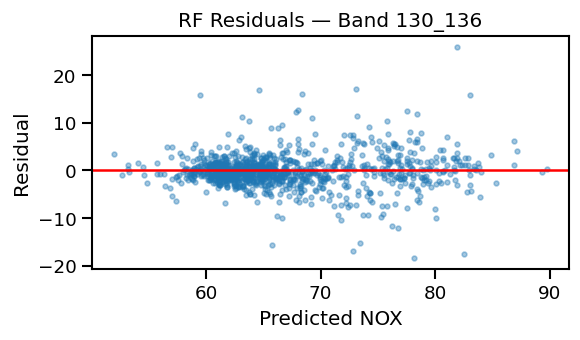


RF — Band 160p | CV R²=0.777±0.046 | Holdout R²=0.820 MAE=1.916 RMSE=2.682 MAPE=2.82%


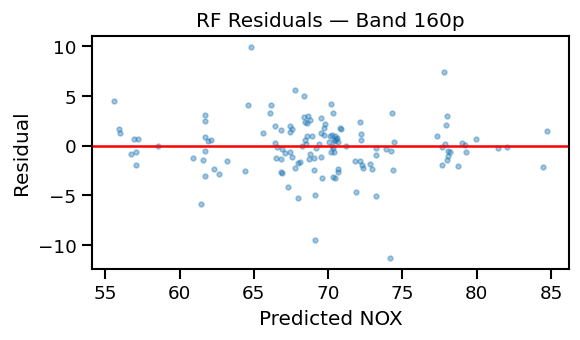

In [7]:
# 6) Random Forest baselines
rf_results = {}
for name, d in bands.items():
    X = d[FEATURES]
    y = d[TARGET]
    rf = RandomForestRegressor(
        n_estimators=600,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=RNG,
        n_jobs=-1
    )
    cvm = cv_r2_mae(rf, X, y, n=5)
    hm, (Xte, yte, yp) = holdout_metrics(rf, X, y)

    print(f"\nRF — Band {name} | CV R²={cvm['cv_r2_mean']:.3f}±{cvm['cv_r2_std']:.3f} | "
          f"Holdout R²={hm['r2']:.3f} MAE={hm['mae']:.3f} RMSE={hm['rmse']:.3f} MAPE={hm['mape']:.2f}%")

    plt.figure(figsize=(5,3))
    res = yte - yp
    plt.scatter(yp, res, s=8, alpha=0.4)
    plt.axhline(0, color="r")
    plt.xlabel("Predicted NOX"); plt.ylabel("Residual")
    plt.title(f"RF Residuals — Band {name}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"rf_residuals_{name}.png")
    plt.show()

    rf_results[name] = {"model": rf, "cv": cvm, "holdout": hm}


[I 2025-11-16 19:32:36,283] A new study created in memory with name: no-name-a7e7ec6b-850f-442a-b559-a2d1b2d69a55
[I 2025-11-16 19:33:03,223] Trial 0 finished with value: 0.7706885103762028 and parameters: {'n_estimators': 742, 'max_depth': 10, 'learning_rate': 0.011029108308194622, 'subsample': 0.644887495640918, 'colsample_bytree': 0.7791657610867928, 'min_child_weight': 6, 'gamma': 4.855766995348889, 'reg_lambda': 13.111199083253082, 'reg_alpha': 2.647045258002647}. Best is trial 0 with value: 0.7706885103762028.
[I 2025-11-16 19:33:11,442] Trial 1 finished with value: 0.6931158184865739 and parameters: {'n_estimators': 532, 'max_depth': 4, 'learning_rate': 0.013948733933757309, 'subsample': 0.6250296160263159, 'colsample_bytree': 0.6048007795685877, 'min_child_weight': 4, 'gamma': 3.4296778084419746, 'reg_lambda': 3.6327194358345345, 'reg_alpha': 6.978618785225558}. Best is trial 0 with value: 0.7706885103762028.
[I 2025-11-16 19:33:21,532] Trial 2 finished with value: 0.7711329843


XGB — Band 130_136 | CV R²=0.791±0.017 | Holdout R²=0.799 MAE=2.282 RMSE=3.457 MAPE=3.35%


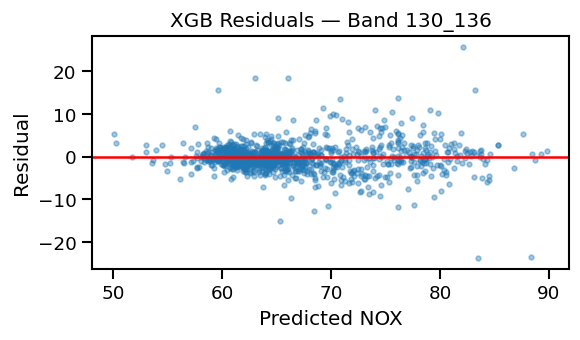

[I 2025-11-16 20:13:45,649] A new study created in memory with name: no-name-7c171f2b-64c4-4be4-ae6b-2f366d9d5996
[I 2025-11-16 20:14:09,733] Trial 0 finished with value: 0.7610144383594852 and parameters: {'n_estimators': 1291, 'max_depth': 9, 'learning_rate': 0.00820993933643027, 'subsample': 0.7679321976885518, 'colsample_bytree': 0.5471856964618431, 'min_child_weight': 9, 'gamma': 4.83305735151352, 'reg_lambda': 12.495055904086229, 'reg_alpha': 7.274417123272761}. Best is trial 0 with value: 0.7610144383594852.
[I 2025-11-16 20:14:32,761] Trial 1 finished with value: 0.776826154594164 and parameters: {'n_estimators': 1328, 'max_depth': 7, 'learning_rate': 0.010947435961531849, 'subsample': 0.6853545636768658, 'colsample_bytree': 0.5928635605223138, 'min_child_weight': 12, 'gamma': 0.5443242045799629, 'reg_lambda': 8.975428260570126, 'reg_alpha': 3.348375149321102}. Best is trial 1 with value: 0.776826154594164.
[I 2025-11-16 20:16:06,548] Trial 2 finished with value: 0.797169157255


XGB — Band 160p | CV R²=0.792±0.035 | Holdout R²=0.819 MAE=1.970 RMSE=2.693 MAPE=2.88%


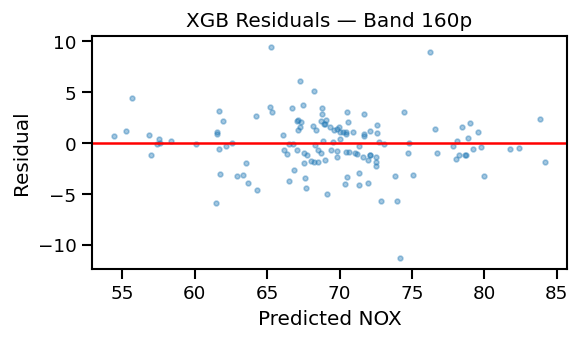

In [8]:
# 7) XGB tuning + fit — stable for all XGBoost >= 2.0
def tune_xgb(X: pd.DataFrame, y: pd.Series, n_trials=40, random_state=RNG):

    def objective(trial):

        params = {
            "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
            "max_depth": trial.suggest_int("max_depth", 4, 18),
            "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.3, log=True),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 12),
            "gamma": trial.suggest_float("gamma", 0.0, 5.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 15.0),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),

            # SAFE IN XGB >= 2.0 → must stay in constructor
            "eval_metric": "rmse",
            "early_stopping_rounds": 50,

            "random_state": RNG,
            "n_jobs": -1
        }

        model = XGBRegressor(**params)
        kf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=RNG)

        scores = []

        for tr, te in kf.split(X):

            # SAFE FIT: only eval_set + verbose allowed
            model.fit(
                X.iloc[tr],
                y.iloc[tr],
                eval_set=[(X.iloc[te], y.iloc[te])],
                verbose=False
            )

            yp = model.predict(X.iloc[te])
            scores.append(r2_score(y.iloc[te], yp))

        return float(np.mean(scores))


    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    return study.best_params



# Fit per band
xgb_results = {}

for name, d in bands.items():

    X = d[FEATURES]
    y = d[TARGET]

    # best params include early_stopping_rounds + eval_metric
    best = tune_xgb(X, y, n_trials=40, random_state=RNG)

    # Final model: KEEP eval_metric, REMOVE early_stopping_rounds for CV
    xgb_model = XGBRegressor(
        **best,
        eval_metric="rmse",
        random_state=RNG,
        n_jobs=-1
    )
    xgb_model.set_params(early_stopping_rounds=None)   # <--- IMPORTANT FIX

    # CV evaluation (early stopping disabled)
    cvm = cv_r2_mae(xgb_model, X, y, n=5)

    # Holdout evaluation (early stopping disabled)
    xgb_model.set_params(early_stopping_rounds=None)   # <--- IMPORTANT FIX
    hm, (Xte, yte, yp) = holdout_metrics(xgb_model, X, y)

    print(
        f"\nXGB — Band {name} | CV R²={cvm['cv_r2_mean']:.3f}"
        f"±{cvm['cv_r2_std']:.3f} | Holdout R²={hm['r2']:.3f} "
        f"MAE={hm['mae']:.3f} RMSE={hm['rmse']:.3f} MAPE={hm['mape']:.2f}%"
    )

    plt.figure(figsize=(5,3))
    res = yte - yp
    plt.scatter(yp, res, s=8, alpha=0.4)
    plt.axhline(0, color="r")
    plt.xlabel("Predicted NOX")
    plt.ylabel("Residual")
    plt.title(f"XGB Residuals — Band {name}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"xgb_residuals_{name}.png")
    plt.show()

    xgb_results[name] = {
        "model": xgb_model,
        "best_params": best,
        "cv": cvm,
        "holdout": hm
    }

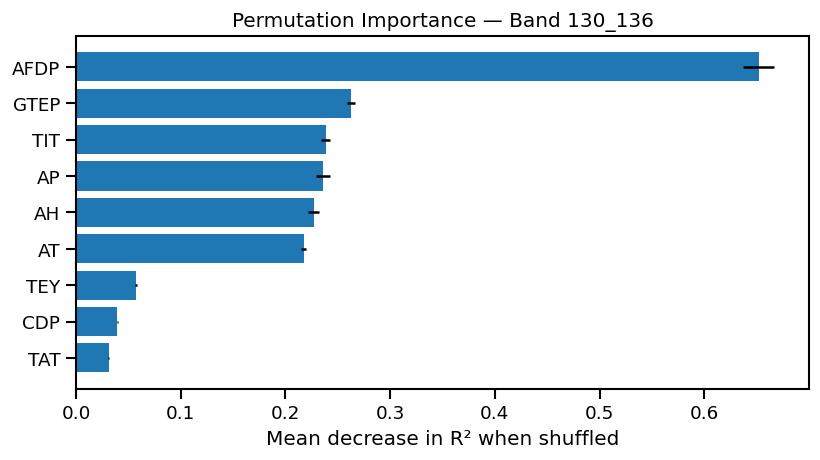

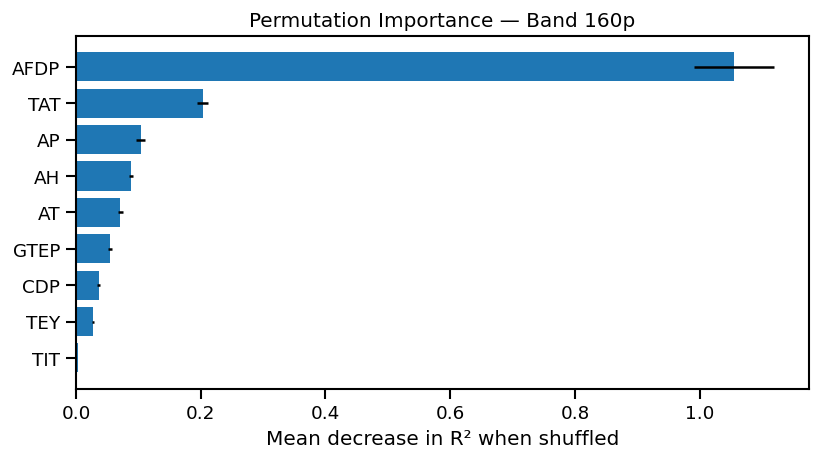

In [9]:
# 8) Permutation importance
for name, d in bands.items():
    X = d[FEATURES]
    y = d[TARGET]
    model = xgb_results[name]["model"]
    model.fit(X, y)  # ensure fitted to full band before PI
    pi = permutation_importance(model, X, y, n_repeats=10, random_state=RNG, n_jobs=-1)
    imp = pd.DataFrame({
        "Feature": X.columns,
        "Importance": pi.importances_mean,
        "Std": pi.importances_std
    }).sort_values("Importance", ascending=True)

    plt.figure(figsize=(7,4))
    plt.barh(imp["Feature"], imp["Importance"], xerr=imp["Std"])
    plt.title(f"Permutation Importance — Band {name}")
    plt.xlabel("Mean decrease in R² when shuffled")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"perm_importance_{name}.png")
    plt.show()

    imp.to_csv(FIG_DIR / f"perm_importance_{name}.csv", index=False)


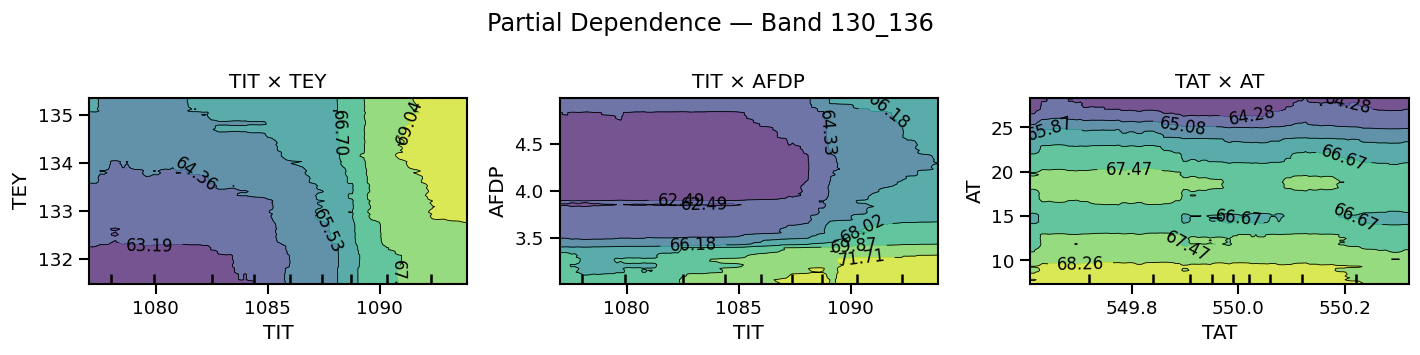

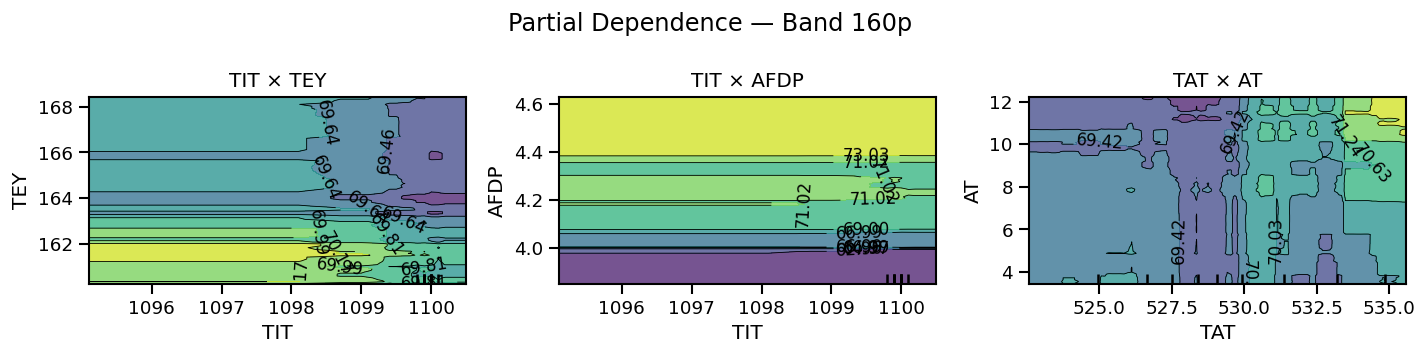

In [10]:
# 9) Partial Dependence panels
# You may update 'pairs' after inspecting permutation importance.
default_top2 = ["TIT", "TAT"]
pairs = [(default_top2[0], "TEY"), (default_top2[0], "AFDP"), (default_top2[1], "AT")]

for name, d in bands.items():
    model = xgb_results[name]["model"]
    X = d[FEATURES]
    fig, ax = plt.subplots(1, len(pairs), figsize=(12,3))
    for i, pair in enumerate(pairs):
        PartialDependenceDisplay.from_estimator(
            model, X, features=[pair], kind="average", ax=ax[i]
        )
        ax[i].set_title(f"{pair[0]} × {pair[1]}")
    plt.suptitle(f"Partial Dependence — Band {name}")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"pdp_pairs_{name}.png")
    plt.show()


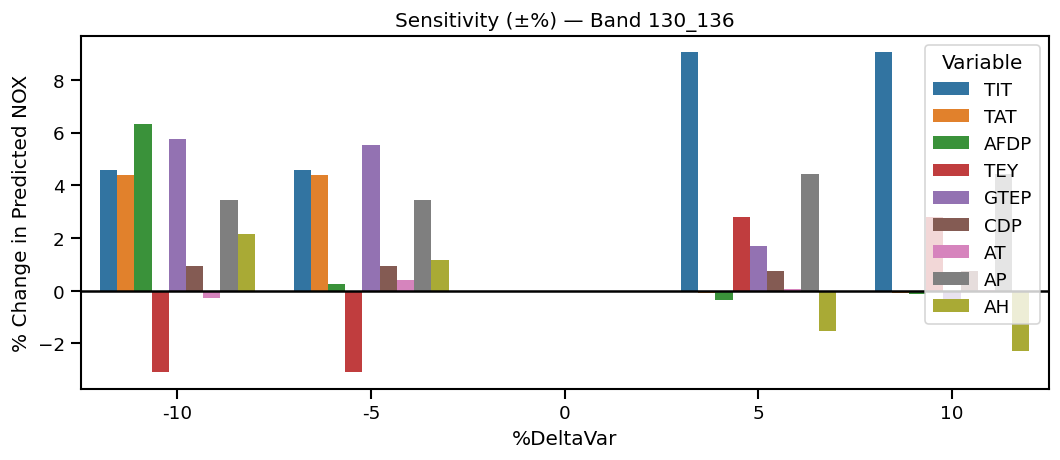

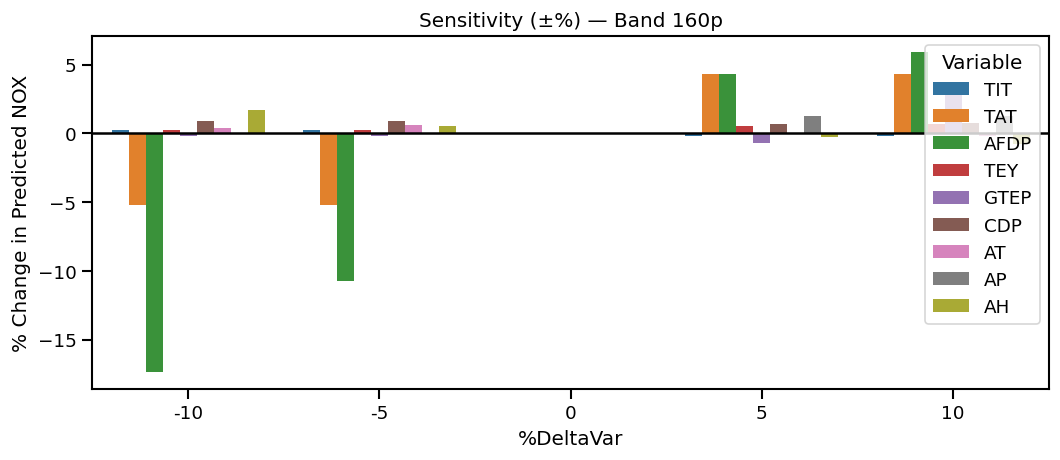

In [11]:
# 10) Sensitivity analysis around band means
PCTS = [-10, -5, 0, 5, 10]

for name, d in bands.items():
    X = d[FEATURES]
    y = d[TARGET]
    model = xgb_results[name]["model"]
    base = X.mean().to_frame().T
    base_pred = float(model.predict(base)[0])

    rows = []
    for group, feats in GROUPS.items():
        for var in feats:
            for pct in PCTS:
                test = base.copy()
                test[var] = base[var].values[0] * (1.0 + pct/100.0)
                pred = float(model.predict(test)[0])
                rows.append([group, var, pct, pred, 100.0 * (pred - base_pred) / base_pred])

    sim = pd.DataFrame(rows, columns=["Group","Variable","%DeltaVar","Pred_NOX","%DeltaNOX"])
    sim.to_csv(FIG_DIR / f"sensitivity_{name}.csv", index=False)

    plt.figure(figsize=(9,4))
    sns.barplot(data=sim, x="%DeltaVar", y="%DeltaNOX", hue="Variable")
    plt.axhline(0, color="black")
    plt.title(f"Sensitivity (±%) — Band {name}")
    plt.ylabel("% Change in Predicted NOX")
    plt.tight_layout()
    plt.savefig(FIG_DIR / f"sensitivity_{name}.png")
    plt.show()


In [12]:
# 11) Save artifacts and JSON metadata
for name, d in bands.items():
    model = xgb_results[name]["model"]
    job_path = ART_DIR / f"nox_xgb_{name}.joblib"
    joblib.dump(model, job_path)

    meta = {
        "model_name": f"NOX_XGB_{name}",
        "version": 1,
        "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "features": FEATURES,
        "band": name,
        "rows": int(len(d)),
        "best_params": xgb_results[name]["best_params"],
        "cv": xgb_results[name]["cv"],
        "holdout": xgb_results[name]["holdout"]
    }
    with open(ART_DIR / f"model_info_{name}.json", "w") as f:
        json.dump(meta, f, indent=2)


In [13]:
# 12) Compact report line per band
for name in bands.keys():
    cv = xgb_results[name]["cv"]
    ho = xgb_results[name]["holdout"]
    print(
        f"{name}: CV R²={cv['cv_r2_mean']:.3f}±{cv['cv_r2_std']:.3f} | "
        f"Holdout R²={ho['r2']:.3f} MAE={ho['mae']:.3f} RMSE={ho['rmse']:.3f} MAPE={ho['mape']:.2f}%"
    )


130_136: CV R²=0.791±0.017 | Holdout R²=0.799 MAE=2.282 RMSE=3.457 MAPE=3.35%
160p: CV R²=0.792±0.035 | Holdout R²=0.819 MAE=1.970 RMSE=2.693 MAPE=2.88%
